In [1]:
# 2021/08/28 업데이트 내용
# 1. 건물연식 5년으로 고정하고, 계약날짜 검색범위만 6개월, 12개월, 24개월, 36개월로 조정
# 2. 전세 포함

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '강동구' # 구 명
target_dong = '천호' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2018 # 검색 시작 계약 년도: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210914'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2018):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df, apart_lease_df]).reset_index(drop=True)
del apart_trade_df, apart_lease_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:00, 32.32it/s]
16it [00:01, 14.72it/s]


(727444, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,130000,4,1987,매매,31,2018-01-03,1625.609604,34,아파트
1,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,117000,2,1987,매매,31,2018-01-08,1463.048643,34,아파트
2,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,130000,1,1987,매매,31,2018-01-11,1625.609604,34,아파트
3,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,79.97,139500,2,1987,매매,31,2018-03-19,1744.404152,34,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,개포6차우성아파트1동~8동,54.98,107500,5,1987,매매,31,2018-04-05,1955.256457,34,아파트


In [10]:
yunrip_trade_df = data_prep('연립다세대', '매매')
yunrip_lease_df = data_prep('연립다세대', '전월세')
yunrip_df = pd.concat([yunrip_trade_df, yunrip_lease_df]).reset_index(drop=True)
del yunrip_trade_df, yunrip_lease_df
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:00, 31.37it/s] 
13it [00:00, 55.31it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
16it [00:00, 20.34it/s]


(430470, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1172-2,논현로6길 22-6,(1172-2),29.95,25000,4,2012.0,매매,6.0,2018-01-13,834.724541,9.0,연립다세대
1,서울특별시 강남구 개포동 1216-4,개포로26길 16,(1216-4),29.12,25300,4,2012.0,매매,6.0,2018-10-23,868.818681,9.0,연립다세대
2,서울특별시 강남구 개포동 1187-8,논현로8길 17,1187-8,55.96,45500,4,2015.0,매매,3.0,2018-01-04,813.080772,6.0,연립다세대
3,서울특별시 강남구 개포동 1187-8,논현로8길 17,1187-8,59.84,51000,3,2015.0,매매,3.0,2018-03-09,852.272727,6.0,연립다세대
4,서울특별시 강남구 개포동 1187-8,논현로8길 17,1187-8,59.84,51000,2,2015.0,매매,3.0,2018-04-14,852.272727,6.0,연립다세대


In [11]:
officetel_trade_df = data_prep('오피스텔', '매매')
officetel_lease_df = data_prep('오피스텔', '전월세')
officetel_df = pd.concat([officetel_trade_df, officetel_lease_df]).reset_index(drop=True)
del officetel_trade_df, officetel_lease_df
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 137.90it/s]
16it [00:00, 49.07it/s]


(137646, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,18500,20,1997.0,매매,21.0,2018-01-02,579.755563,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,19900,14,1997.0,매매,21.0,2018-01-04,623.628956,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,20000,26,1997.0,매매,21.0,2018-01-08,616.522811,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,20000,26,1997.0,매매,21.0,2018-01-18,616.522811,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,21000,22,1997.0,매매,21.0,2018-01-20,647.348952,24.0,오피스텔


In [12]:
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df, yunrip_df, officetel_df
print(house_df.shape)
house_df.head()

(1295560, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1163-4,논현로 10,(1163-4),13.56,10000,5,2013.0,전세,5.0,2018-07-09,737.463127,8.0,연립다세대
1,서울특별시 강남구 개포동 1163-4,논현로 10,(1163-4),21.88,15000,4,2013.0,전세,5.0,2018-04-03,685.557587,8.0,연립다세대
2,서울특별시 강남구 개포동 1163-4,논현로 10,(1163-4),21.88,15000,3,2013.0,전세,6.0,2019-02-24,685.557587,8.0,연립다세대
3,서울특별시 강남구 개포동 1163-4,논현로 10,(1163-4),21.88,16000,4,2013.0,전세,6.0,2019-03-16,731.261426,8.0,연립다세대
4,서울특별시 강남구 개포동 1163-4,논현로 10,(1163-4),21.88,16000,3,2013.0,전세,6.0,2019-04-02,731.261426,8.0,연립다세대


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
house_df['일괄계약'] = 'N'

In [18]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [19]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [20]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [21]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(1053, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
130288,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25000,2,2020.0,전세,1.0,2021-06-16,863.557858,1.0,연립다세대,강동구,천호동,N
130316,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),46.65,30400,6,2016.0,전세,5.0,2021-03-16,651.661308,5.0,연립다세대,강동구,천호동,N
130364,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,25.68,25000,5,2018.0,전세,3.0,2021-03-17,973.520249,3.0,연립다세대,강동구,천호동,N
130365,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,25.68,21000,4,2018.0,전세,3.0,2021-07-26,817.757009,3.0,연립다세대,강동구,천호동,N
130368,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,27.54,23000,6,2018.0,전세,3.0,2021-05-08,835.148874,3.0,연립다세대,강동구,천호동,N


In [22]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(2246, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
130284,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,24000,3,2020.0,전세,0.0,2020-09-25,835.363731,1.0,연립다세대,강동구,천호동,N
130287,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25500,4,2020.0,전세,0.0,2020-09-15,880.829016,1.0,연립다세대,강동구,천호동,N
130288,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25000,2,2020.0,전세,1.0,2021-06-16,863.557858,1.0,연립다세대,강동구,천호동,N
130289,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,29.41,28500,5,2020.0,전세,0.0,2020-09-26,969.058143,1.0,연립다세대,강동구,천호동,N
130316,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),46.65,30400,6,2016.0,전세,5.0,2021-03-16,651.661308,5.0,연립다세대,강동구,천호동,N


In [23]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(4996, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
130278,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,3,2020.0,전세,0.0,2020-06-22,779.458964,1.0,연립다세대,강동구,천호동,N
130279,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N
130280,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-24,1115.656378,1.0,연립다세대,강동구,천호동,N
130281,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N
130282,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,23500,2,2020.0,전세,0.0,2020-09-09,817.960320,1.0,연립다세대,강동구,천호동,N


In [24]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(6557, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
130278,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,3,2020.0,전세,0.0,2020-06-22,779.458964,1.0,연립다세대,강동구,천호동,N
130279,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N
130280,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-24,1115.656378,1.0,연립다세대,강동구,천호동,N
130281,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N
130282,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,23500,2,2020.0,전세,0.0,2020-09-09,817.960320,1.0,연립다세대,강동구,천호동,N


In [25]:
target_1_12_df = identify_bulk_contract(target_1_12_df)

100%|███████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 536.87it/s]


In [26]:
target_2_24_df = identify_bulk_contract(target_2_24_df)

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 352.03it/s]


In [27]:
target_3_36_df = identify_bulk_contract(target_3_36_df)

100%|███████████████████████████████████████████████████████████████████████████████| 311/311 [00:01<00:00, 260.19it/s]


In [28]:
target_5_60_df = identify_bulk_contract(target_5_60_df)

100%|███████████████████████████████████████████████████████████████████████████████| 338/338 [00:01<00:00, 215.10it/s]


In [29]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [30]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [31]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['지수적용날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '지수적용날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [32]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(1053, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
130288,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25000,2,2020.0,전세,1.0,2021-06-16,863.557858,1.0,연립다세대,강동구,천호동,N,863.557858,2021-06-16
130316,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),46.65,30400,6,2016.0,전세,5.0,2021-03-16,651.661308,5.0,연립다세대,강동구,천호동,N,672.856647,2021-05-01
130364,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,25.68,25000,5,2018.0,전세,3.0,2021-03-17,973.520249,3.0,연립다세대,강동구,천호동,N,1005.184079,2021-05-01
130365,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,25.68,21000,4,2018.0,전세,3.0,2021-07-26,817.757009,3.0,연립다세대,강동구,천호동,N,817.757009,2021-07-26
130368,서울특별시 강동구 천호동 113-41,천중로 147,성심하이빌,27.54,23000,6,2018.0,전세,3.0,2021-05-08,835.148874,3.0,연립다세대,강동구,천호동,N,835.148874,2021-05-08


In [33]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(2246, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
130284,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,24000,3,2020.0,전세,0.0,2020-09-25,835.363731,1.0,연립다세대,강동구,천호동,N,907.626688,2021-05-01
130287,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25500,4,2020.0,전세,0.0,2020-09-15,880.829016,1.0,연립다세대,강동구,천호동,N,957.024937,2021-05-01
130288,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25000,2,2020.0,전세,1.0,2021-06-16,863.557858,1.0,연립다세대,강동구,천호동,N,863.557858,2021-06-16
130289,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,29.41,28500,5,2020.0,전세,0.0,2020-09-26,969.058143,1.0,연립다세대,강동구,천호동,N,1052.886306,2021-05-01
130316,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),46.65,30400,6,2016.0,전세,5.0,2021-03-16,651.661308,5.0,연립다세대,강동구,천호동,N,672.856647,2021-05-01


In [34]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(4996, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
130278,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,3,2020.0,전세,0.0,2020-06-22,779.458964,1.0,연립다세대,강동구,천호동,N,872.915921,2021-05-01
130279,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N,862.137885,2021-05-01
130280,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-24,1115.656378,1.0,연립다세대,강동구,천호동,N,1232.873612,2021-05-01
130281,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N,1232.873612,2021-05-01
130282,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,23500,2,2020.0,전세,0.0,2020-09-09,817.960320,1.0,연립다세대,강동구,천호동,N,888.717799,2021-05-01


In [35]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(6557, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
130278,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,3,2020.0,전세,0.0,2020-06-22,779.458964,1.0,연립다세대,강동구,천호동,N,872.915921,2021-05-01
130279,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N,862.137885,2021-05-01
130280,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-24,1115.656378,1.0,연립다세대,강동구,천호동,N,1232.873612,2021-05-01
130281,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N,1232.873612,2021-05-01
130282,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,23500,2,2020.0,전세,0.0,2020-09-09,817.960320,1.0,연립다세대,강동구,천호동,N,888.717799,2021-05-01


In [36]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[['지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [37]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[['지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [38]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[['지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [39]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[['지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [40]:
target_df = target_3_36_df.copy()

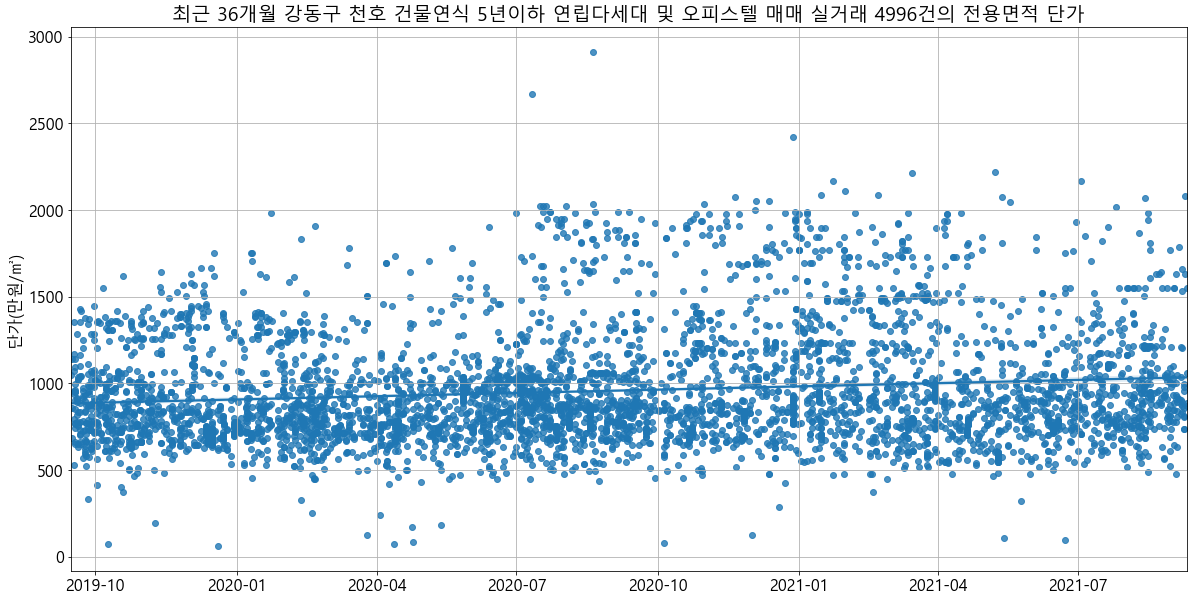

In [41]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [42]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

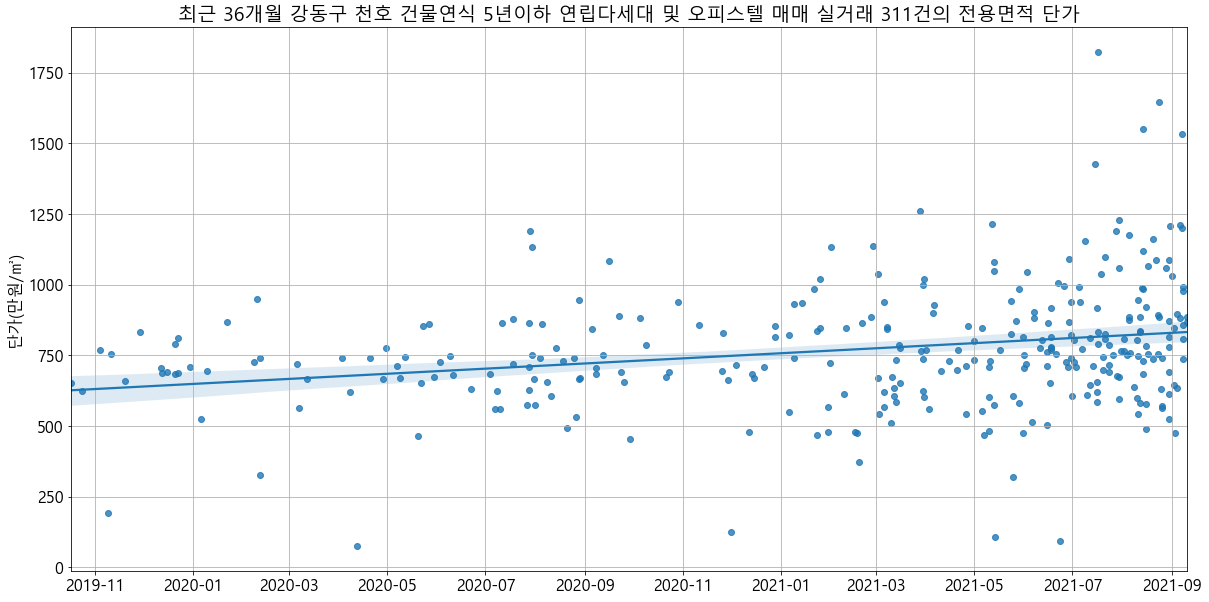

In [43]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [44]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [45]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(8866, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
130278,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,3,2020.0,전세,0.0,2020-06-22,779.458964,1.0,연립다세대,강동구,천호동,N
130279,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N
130280,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-24,1115.656378,1.0,연립다세대,강동구,천호동,N
130281,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N
130282,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,23500,2,2020.0,전세,0.0,2020-09-09,817.960320,1.0,연립다세대,강동구,천호동,N


In [46]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강동구 천호 계약날짜기준 건물연식 5년이하 연립다세대 및 오피스텔 매매 실거래 8866건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

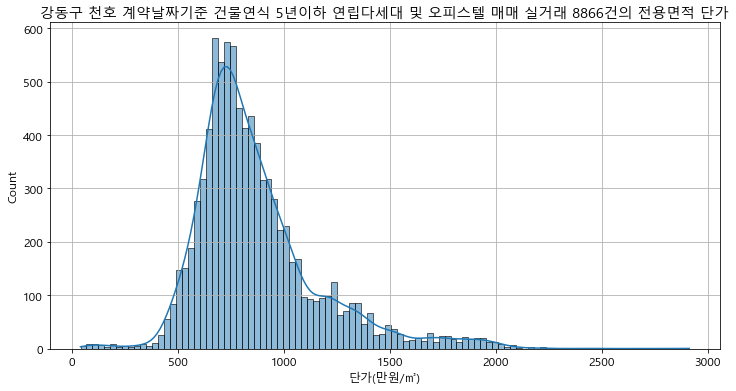

In [47]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [48]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [49]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [50]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [51]:
concat_df = pd.concat([target_df2])

In [52]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [53]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [54]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(2130, 20)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,21.81,17000,2,2020.0,전세,0.0,2020-07-02,779.458964,1.0,연립다세대,강동구,천호동,N,862.137885,2021-05-01,906.223086,980.863134
1,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,26.89,30000,5,2020.0,전세,0.0,2020-08-29,1115.656378,1.0,연립다세대,강동구,천호동,N,1232.873612,2021-05-01,906.223086,980.863134
2,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.73,24000,3,2020.0,전세,0.0,2020-09-25,835.363731,1.0,연립다세대,강동구,천호동,N,907.626688,2021-05-01,906.223086,980.863134
3,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,29.41,28500,5,2020.0,전세,0.0,2020-09-26,969.058143,1.0,연립다세대,강동구,천호동,N,1052.886306,2021-05-01,906.223086,980.863134
4,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,29.74,26000,3,2020.0,전세,0.0,2020-08-18,874.243443,1.0,연립다세대,강동구,천호동,N,966.096455,2021-05-01,906.223086,980.863134


In [55]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(459, 20)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
5,서울특별시 강동구 천호동 110-22,천중로31길 10,모던하우스,28.95,25000,2,2020.0,전세,1.0,2021-06-16,863.557858,1.0,연립다세대,강동구,천호동,N,863.557858,2021-06-16,906.223086,980.863134
7,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,37.99,25000,5,2015.0,전세,4.0,2019-12-17,658.067913,6.0,연립다세대,강동구,천호동,N,767.713097,2021-05-01,689.472249,775.230032
9,서울특별시 강동구 천호동 110-31,천중로35길 19,드림하우스 천동,40.94,24700,3,2014.0,매매,5.0,2019-03-05,603.321935,7.0,연립다세대,강동구,천호동,N,738.774670,2021-05-01,551.994746,674.071934
15,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),49.17,29300,2,2016.0,전세,5.0,2021-01-25,595.891804,5.0,연립다세대,강동구,천호동,N,621.081883,2021-05-01,765.462963,840.664051
18,서울특별시 강동구 천호동 113-22,천중로34길 10,런던빌C,44.67,28000,2,2016.0,전세,4.0,2020-07-28,626.818894,5.0,연립다세대,강동구,천호동,N,693.306949,2021-05-01,708.035360,765.851498


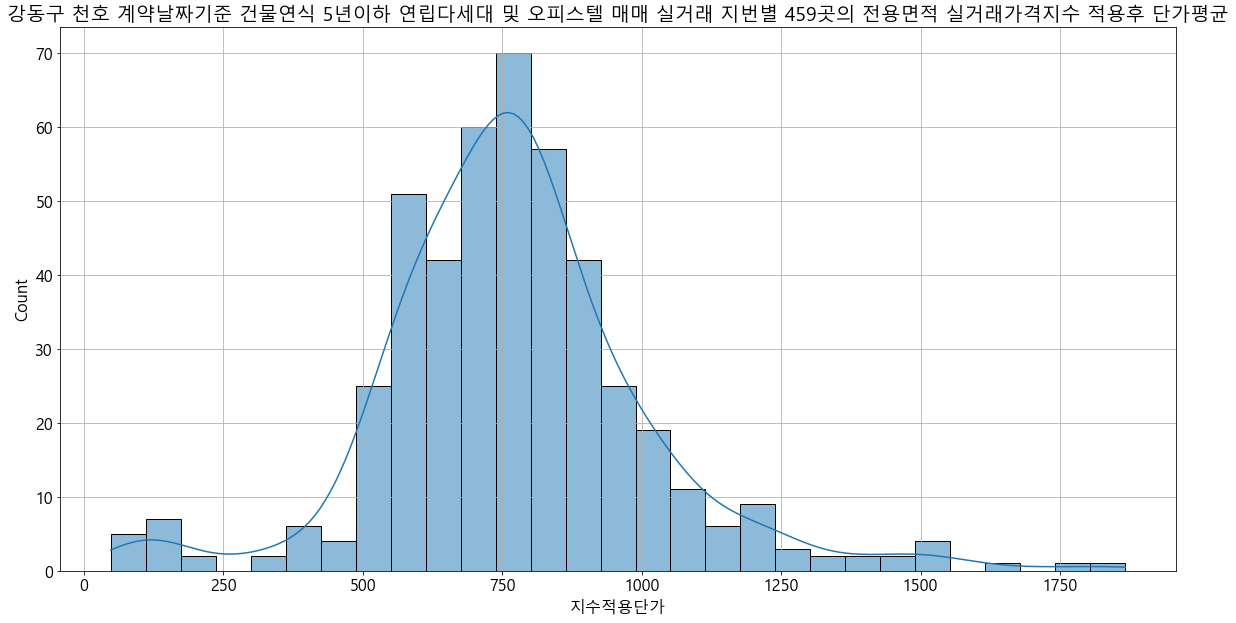

In [56]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [57]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [58]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 강동구 천호동 110-22,모던하우스,2020.0,28.95,2,2021-06-16,863.557858,2021-06-16,863.557858,연립다세대
1,서울특별시 강동구 천호동 110-3,세림 힐 하우스,2015.0,37.99,5,2019-12-17,658.067913,2021-05-01,767.713097,연립다세대
2,서울특별시 강동구 천호동 110-31,드림하우스 천동,2014.0,40.94,3,2019-03-05,603.321935,2021-05-01,738.774670,연립다세대
3,서울특별시 강동구 천호동 112-1,(112-1),2016.0,49.17,2,2021-01-25,595.891804,2021-05-01,621.081883,연립다세대
4,서울특별시 강동구 천호동 113-22,런던빌C,2016.0,44.67,2,2020-07-28,626.818894,2021-05-01,693.306949,연립다세대


In [59]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)